## 动量法
在 11.4节⼀节中，我们详述了如何执⾏随机梯度下降，即在只有嘈杂的梯度可⽤的情况下执⾏优化时会发⽣
什么。对于嘈杂的梯度，我们在选择学习率需要格外谨慎。如果衰减速度太快，收敛就会停滞。相反，如果
太宽松，我们可能⽆法收敛到最优解。

### 基础
本节将探讨更有效的优化算法，尤其是针对实验中常⻅的某些类型的优化问题。

#### 泄露平均值
上⼀节中我们讨论了⼩批量随机梯度下降作为加速计算的⼿段。它也有很好的副作⽤，即平均梯度减⼩了⽅
差。⼩批量随机梯度下降可以通过以下⽅式计算：

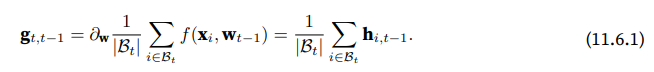

为了保持记法简单，在这⾥我们使⽤hi,t−1 = ∂wf(xi, wt−1)作为样本i的随机梯度下降，使⽤时间t − 1时更新
的权重t − 1。如果我们能够从⽅差减少的影响中受益，甚⾄超过⼩批量上的梯度平均值，那很不错。完成这
项任务的⼀种选择是⽤泄漏平均值（leaky average）取代梯度计算：

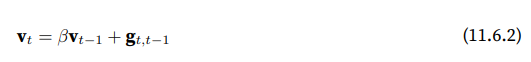

其中β ∈ (0, 1)。这有效地将瞬时梯度替换为多个“过去”梯度的平均值。v被称为动量（momentum），它累
加了过去的梯度。为了更详细地解释，让我们递归地将vt扩展到

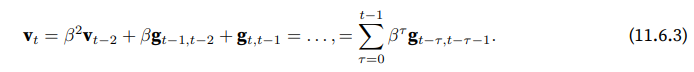

其中，较⼤的β相当于⻓期平均值，⽽较⼩的β相对于梯度法只是略有修正。新的梯度替换不再指向特定实例
下降最陡的⽅向，⽽是指向过去梯度的加权平均值的⽅向。这使我们能够实现对单批量计算平均值的⼤部分
好处，⽽不产⽣实际计算其梯度的代价。

上述推理构成了”加速”梯度⽅法的基础，例如具有动量的梯度。在优化问题条件不佳的情况下（例如，有
些⽅向的进展⽐其他⽅向慢得多，类似狭窄的峡⾕），”加速”梯度还额外享受更有效的好处。此外，它们允
许我们对随后的梯度计算平均值，以获得更稳定的下降⽅向。诚然，即使是对于⽆噪声凸问题，加速度这⽅
⾯也是动量如此起效的关键原因之⼀。

正如⼈们所期望的，由于其功效，动量是深度学习及其后优化中⼀个深⼊研究的主题。例如，请参阅⽂章134，
观看深⼊分析和互动动画。动量是由 (Polyak, 1964)提出的。(Nesterov, 2018)在凸优化的背景下进⾏了详细
的理论讨论。⻓期以来，深度学习的动量⼀直被认为是有益的。有关实例的详细信息，请参阅 (Sutskever et
al., 2013)的讨论。

#### 条件不佳的问题
为了更好地了解动量法的⼏何属性，我们复习⼀下梯度下降，尽管它的⽬标函数明显不那么令⼈愉快。回想
我们在 11.3节中使⽤了f(x) = x21 + 2x22，即中度扭曲的椭球⽬标。我们通过向x1⽅向伸展它来进⼀步扭曲这
个函数
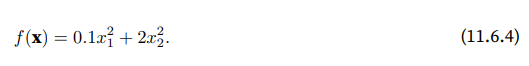

与之前⼀样，f在(0, 0)有最⼩值，该函数在x1的⽅向上⾮常平坦。让我们看看在这个新函数上执⾏梯度下降
时会发⽣什么。


d:\anaconda3\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


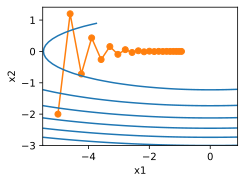

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

eta = 0.4
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2
def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))


从构造来看，x2⽅向的梯度⽐⽔平x1⽅向的梯度⼤得多，变化也快得多。因此，我们陷⼊两难：如果选择较
⼩的学习率，我们会确保解不会在x2⽅向发散，但要承受在x1⽅向的缓慢收敛。相反，如果学习率较⾼，我
们在x1⽅向上进展很快，但在x2⽅向将会发散。下⾯的例⼦说明了即使学习率从0.4略微提⾼到0.6，也会发
⽣变化。x1⽅向上的收敛有所改善，但整体来看解的质量更差了。


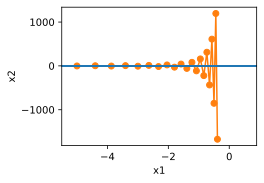

In [2]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))


#### 动量法
动量法（momentum）使我们能够解决上⾯描述的梯度下降问题。观察上⾯的优化轨迹，我们可能会直觉到
计算过去的平均梯度效果会很好。毕竟，在x1⽅向上，这将聚合⾮常对⻬的梯度，从⽽增加我们在每⼀步中
覆盖的距离。相反，在梯度振荡的x2⽅向，由于相互抵消了对⽅的振荡，聚合梯度将减⼩步⻓⼤⼩。使⽤vt⽽
不是梯度gt可以⽣成以下更新等式：

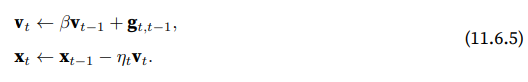

请注意，对于β = 0，我们恢复常规的梯度下降。在深⼊研究它的数学属性之前，让我们快速看⼀下算法在实
验中的表现如何。

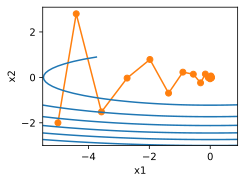

In [3]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

eta, beta = 0.6, 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

正如所⻅，尽管学习率与我们以前使⽤的相同，动量法仍然很好地收敛了。让我们看看当降低动量参数时会
发⽣什么。将其减半⾄β = 0.25会导致⼀条⼏乎没有收敛的轨迹。尽管如此，它⽐没有动量时解将会发散要
好得多。

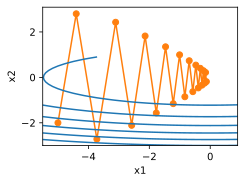

In [4]:
eta, beta = 0.6, 0.25
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))


请注意，我们可以将动量法与随机梯度下降，特别是⼩批量随机梯度下降结合起来。唯⼀的变化是，在这种
情况下，我们将梯度gt,t−1替换为gt。为了⽅便起⻅，我们在时间t = 0初始化v0 = 0。

#### 有效样本权重
回想⼀下vt =∑t−1τ=0 βτgt−τ,t−τ−1。极限条件下，∑∞
τ=0 βτ =11−β。换句话说，不同于在梯度下降或者随机梯
度下降中取步⻓η，我们选取步⻓ η1−β，同时处理潜在表现可能会更好的下降⽅向。这是集两种好处于⼀⾝的
做法。为了说明β的不同选择的权重效果如何，请参考下⾯的图表。


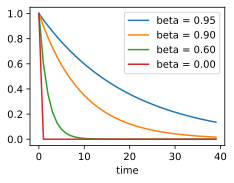

In [5]:
d2l.set_figsize()
betas = [0.95, 0.9, 0.6, 0]
for beta in betas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(x, beta ** x, label=f'beta = {beta:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();
